# Group assignment on natural language processing

**Group members:** Suuraj Perpeli, Veikka Immonen

In this assignment we analyze performance of machine learning models
for natural language processing (NLP) tasks, using 🤗 Hugging Face.

## Install depencies

This notebook is designed to be used in Google Colab out-of-the-box (by definition of you don't have to do anything else outside of Colab session).
First, install required depencies by using pip...

In [1]:
!pip3 install -U -q datasets transformers accelerate bitsandbytes hnswlib peft wandb openai-whisper ffmpeg-python

...and import them

In [2]:
import torch

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from transformers import (AutoModelForCausalLM, AutoTokenizer, pipeline,
                          BitsAndBytesConfig, TrainingArguments, Trainer,
                          DataCollatorForLanguageModeling, AutoModel,
                          AutoProcessor)
from datasets import load_dataset, concatenate_datasets

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from huggingface_hub import login
import wandb

import hnswlib

import os
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm

from gensim.models.word2vec import Word2Vec

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import scipy
import io
import ffmpeg
from sklearn.manifold import TSNE
import random

import whisper

## Load the dataset

We chose the Medical Meadow Medical Flashcards dataset presented by Han et al. (2023) (paper [here](https://arxiv.org/pdf/2304.08247)). This is the first subset out of four published subsets, consisting of QA flashcards of medical based questions.

The dataset can be loaded using 🤗 Datasets.

In [3]:
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print('Structure of data: ', ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

(…)l_meadow_wikidoc_medical_flashcards.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Structure of data:  DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


The data is a dictionary ```train``` as the key and another dictionary ```Dataset```  as the value, the keys of this dictinoary are ```features``` and ```num_rows```, features being one of the ```input```, ```output```, or ```instruction```.

The ```num_rows``` suggests that there are 33955 questions and answers with instructions respectively.

Let us have a look at how each one of these are:

In [4]:
print(f'Input :', ds['train']['input'][0])
print(f'Output :', ds['train']['output'][0])
print(f'Instruction :', ds['train']['instruction'][0])

Input : What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Output : Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
Instruction : Answer this question truthfully


The ```input```'s are questions,

The ```output```'s are answers and,

The ```instruction```'s are the instructions to answer the questions.

The dataset has also few empty prompts. Let's remove them.

In [5]:
ds = ds.filter(lambda example: len(example['input']) > 0)
ds

Filter:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33547
    })
})

## Initial analysis on the data

Let's analyze the output sentences and the train a Word2Vec model by them.

First, lowercase the text, tokenizing based on spaces to prepare the text for training. Using regex, character `\W` removes the non word characters thereby removing the '+','/','-' that however could be good to keep.

In [6]:
tokenized_sentences = [re.sub(r'\W', ' ', sentence).lower().split() for sentence in ds['train']['output']]

for i in tokenized_sentences[:5]:
  print(i)

print(f'Minimum sentence len: ', min([len(i)for i in tokenized_sentences]))
print(f'Maximum sentence len: ', max([len(i)for i in tokenized_sentences]))
print(f'Average sentence len: ', np.mean([len(i)for i in tokenized_sentences]))

['very', 'low', 'mg2', 'levels', 'correspond', 'to', 'low', 'pth', 'levels', 'which', 'in', 'turn', 'results', 'in', 'low', 'ca2', 'levels']
['low', 'estradiol', 'production', 'leads', 'to', 'genitourinary', 'syndrome', 'of', 'menopause', 'atrophic', 'vaginitis']
['low', 'rem', 'sleep', 'latency', 'and', 'experiencing', 'hallucinations', 'sleep', 'paralysis', 'suggests', 'narcolepsy']
['pth', 'independent', 'hypercalcemia', 'which', 'can', 'be', 'caused', 'by', 'cancer', 'granulomatous', 'disease', 'or', 'vitamin', 'd', 'intoxication']
['the', 'level', 'of', 'anti', 'müllerian', 'hormone', 'is', 'directly', 'related', 'to', 'ovarian', 'reserve', 'a', 'lower', 'level', 'indicates', 'a', 'lower', 'ovarian', 'reserve']
Minimum sentence len:  1
Maximum sentence len:  247
Average sentence len:  54.90207768205801


We can also visualize the distribution of lenght of tokenized sentences.

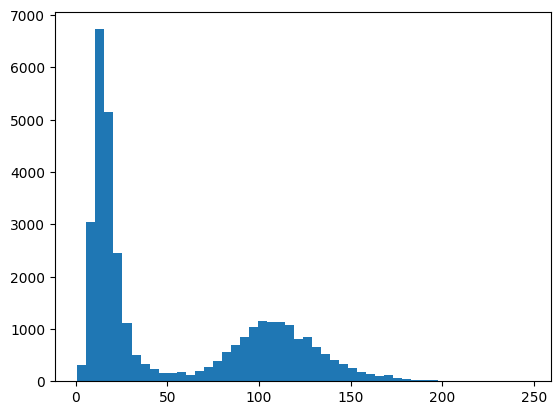

In [7]:
plt.hist([len(sen) for sen in tokenized_sentences], 50)
plt.show()

Now let's train the Word2Vec on the ```outputs```.

In [8]:
model = Word2Vec(tokenized_sentences, vector_size=100, min_count=2, window=10)
print(f'Learnt vectors: ',len(model.wv))

Learnt vectors:  17676


One thing to try is to find most similar words using different terms.


In [9]:
term = 'sickness'
# term = 'fever'
# term = 'cure'
# term = 'drugs'

sims = model.wv.most_similar(term, topn=5)
sims

[('intoxication', 0.6634901165962219),
 ('eosinophilia', 0.6519532799720764),
 ('atypical', 0.6286211609840393),
 ('polyneuropathy', 0.6146089434623718),
 ('urticaria', 0.6107684969902039)]

### Multiple choice questions from the USMLE

For more comprehensive evaluation. Questions from the United States Medical Licensing Examination (USMLE)
question base.

In [10]:
usmle = load_dataset("GBaker/MedQA-USMLE-4-options")
usmle = concatenate_datasets([usmle['train'], usmle['test']])
print('Structure of data: ', usmle)

README.md:   0%|          | 0.00/654 [00:00<?, ?B/s]

phrases_no_exclude_train.jsonl:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

phrases_no_exclude_test.jsonl:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Structure of data:  Dataset({
    features: ['question', 'answer', 'options', 'meta_info', 'answer_idx', 'metamap_phrases'],
    num_rows: 11451
})


In [11]:
id = 1
print(f'Question :', usmle[id]['question'])
print(f'Options :', usmle[id]['options'])
print(f'Answer :', usmle[id]['answer'])

Question : A 3-month-old baby died suddenly at night while asleep. His mother noticed that he had died only after she awoke in the morning. No cause of death was determined based on the autopsy. Which of the following precautions could have prevented the death of the baby?
Options : {'A': 'Placing the infant in a supine position on a firm mattress while sleeping', 'B': 'Keeping the infant covered and maintaining a high room temperature', 'C': 'Application of a device to maintain the sleeping position', 'D': 'Avoiding pacifier use during sleep'}
Answer : Placing the infant in a supine position on a firm mattress while sleeping


## Retrieval-based chatbot

Let's build a QA chatbot based on a semantic search pipeline. Given a question
the bot tries to find a answer from a predefined corpus.

The model can be created by using SentenceTransformers.

In [12]:
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Create the corpus and use Approximate Nearest Neighbor (ANN) to speed-up the search using corpus embeddings.

In [13]:
index_path = './hnswlib.index'
corpus = np.array(ds['train']['output'][:])

if not os.path.exists(index_path):
  print("Creating a HNSWLIB index")
  corpus_embeddings = semb_model.encode(corpus, convert_to_tensor=True,
                                        show_progress_bar=True)
  index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))
  index.init_index(max_elements=corpus_embeddings.size(0),
                   ef_construction=256, M=64)
  index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
  print("Saving index to:", index_path)
  index.save_index(index_path)
else:
  empty_embeddings = semb_model.encode(corpus[:1], convert_to_tensor=True)
  index = hnswlib.Index(space='cosine', dim=empty_embeddings.size(1))
  index.load_index(index_path)


Creating a HNSWLIB index


Batches:   0%|          | 0/1049 [00:00<?, ?it/s]

Saving index to: ./hnswlib.index


Test the ranking using question encoder and ANN.

In [14]:
sample = 0
query = ds['train']['input'][sample]
print(f'Query : {query}')
query_embedding = semb_model.encode(query, convert_to_tensor=True)
ids, distances = index.knn_query(query_embedding.cpu(), k=32)
out = ds['train']['output'][ids[0][np.argmin(distances[0])]]
print(f'Out : {out}')
print(f"True: {ds['train']['output'][sample]}")

Query : What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Out : Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
True: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


Test the re-ranking using the cross-encoder.

In [15]:
model_inputs = [(query, corpus[i]) for i in ids[0]]
cross_scores = xenc_model.predict(model_inputs)
print("Cross-encoder model re-ranking results")
print(f"Query: \"{query} \"")
print("-------------------------")
for idx in np.argsort(-cross_scores)[:5]:
  print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{corpus[ids[0][idx]]}\"")

Cross-encoder model re-ranking results
Query: "What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels? "
-------------------------
Score: 8.8953
Document: "Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels."
Score: 4.0440
Document: "Low Ca2+ and low PTH is seen in primary hypoparathyroidism."
Score: 3.1054
Document: "A severe decrease in serum Mg2+ concentration causes a decrease in PTH secretion. PTH (parathyroid hormone) is a hormone that regulates calcium and phosphate homeostasis in the body. When magnesium levels are low, PTH secretion decreases, which can lead to hypocalcemia (low calcium levels) and other related disorders."
Score: 2.8956
Document: "Severe decreases in serum Mg2+ concentration cause a decrease in PTH secretion. PTH (parathyroid hormone) is a hormone that regulates calcium and phosphate homeostasis in the body, and its secretion is influenced by the levels of magnesium in the blood. When magnesi

Generate the responce function.

Note that the function `chatbot` takes a list (or `np.array`) of questions. In case of one question, put it in a list.

In [16]:
def chatbot(questions, index=index, corpus=corpus, semb_model=semb_model, xenc_model=xenc_model, top_k=32):

    questions = np.array(questions)
    question_embedding = semb_model.encode(questions, convert_to_tensor=True).cpu()
    corpus_ids, _ = index.knn_query(question_embedding, k=top_k)

    answers = corpus[corpus_ids]
    questions = np.stack([questions for _ in range(top_k)], 1)
    pairs = np.stack([questions, answers], 2)

    scores = np.stack([xenc_model.predict(pair) for pair in pairs])
    idx = np.argmax(scores, 1, keepdims=True)
    answers = np.take_along_axis(answers, idx, 1).flatten()

    return answers

In [17]:
def retrive_context(query, semb_model=semb_model, index=index, n=1):
    query_embedding = semb_model.encode(query, convert_to_tensor=True)
    ids, distances = index.knn_query(query_embedding.cpu(), k=32)
    if distances[0][0] > 0.4:
      return None
    context_list = [corpus[i] for i in ids[0][:n]]
    context = ' '.join(context_list)
    return context

Test the chatbot.

In [18]:
start, end = 0, 3000
questions = np.array(ds['train']['input'])[:]
true = corpus[:]

batch_size = 128
iterator = tqdm(range(0, len(questions), batch_size))
pred = np.concatenate([chatbot(questions[i: i+batch_size]) for i in iterator])


  0%|          | 1/263 [00:08<37:51,  8.67s/it]

KeyboardInterrupt: 

In [ ]:
print((pred == true).mean())

0.8796017527647778


## Integrating speech-to-text and text-to-speech functionality

Load Whisper from OpenAI for S2T.

In [19]:
whisper_model = whisper.load_model("small")


  0%|                                               | 0.00/461M [00:00<?, ?iB/s]
  0%|▏                                     | 1.88M/461M [00:00<00:24, 19.4MiB/s]
  1%|▍                                     | 5.94M/461M [00:00<00:14, 32.7MiB/s]
  2%|▉                                     | 10.7M/461M [00:00<00:11, 40.6MiB/s]
  4%|█▍                                    | 16.7M/461M [00:00<00:09, 48.8MiB/s]
  5%|█▉                                    | 23.7M/461M [00:00<00:08, 57.3MiB/s]
  6%|██▍                                   | 29.2M/461M [00:00<00:08, 51.5MiB/s]
  7%|██▊                                   | 34.2M/461M [00:00<00:09, 45.6MiB/s]
  9%|███▎                                  | 39.7M/461M [00:00<00:09, 49.0MiB/s]
 10%|███▋                                  | 44.5M/461M [00:00<00:09, 48.5MiB/s]
 11%|████                                  | 49.3M/461M [00:01<00:09, 48.0MiB/s]
 12%|████▍                                 | 53.9M/461M [00:01<00:08, 47.5MiB/s]
 13%|████▊                 

Load Tacotron 2 + WaveGlow from NVIDIA for T2S

In [22]:
tts_utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [23]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

Audio recording function.


References:
- https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
-https://stackoverflow.com/a/18650249
-https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
-https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
-https://stackoverflow.com/a/49019356



In [24]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    return audio, sr

Testing, testing...

In [26]:
audio, sr = get_audio()

In [27]:
scipy.io.wavfile.write('./tmp.wav', sr, audio)
recording = whisper.load_audio("./tmp.wav")
recording = whisper.pad_or_trim(recording)

In [28]:
mel = whisper.log_mel_spectrogram(recording).to(whisper_model.device)

# Use the mel spectrogram to detect the language
_, probs = whisper_model.detect_language(mel)
lang = max(probs, key=probs.get)

# Print result
print(f"Detected language: {lang}, confidence: {probs[lang]}")

Detected language: en, confidence: 0.3986731767654419


And the results:

In [29]:
# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(whisper_model, mel, options)

# print the recognized text
print(result.text)


Testing testing one two three


Finally, turn it back to voice.

In [30]:
sequences, lengths = tts_utils.prepare_input_sequence([result.text])
sequences

tensor([[57, 42, 56, 57, 46, 51, 44, 11, 57, 42, 56, 57, 46, 51, 44, 11, 52, 51,
         42, 11, 57, 60, 52, 11, 57, 45, 55, 42, 42]], device='cuda:0')

In [31]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel).cpu().numpy().squeeze()

In [32]:
rate = 23000
Audio(audio, rate=rate)

Wrapping things up:

In [33]:
def s2s_chatbot(rate=23000, method='zero'):

    input_audio, input_rate = get_audio()
    scipy.io.wavfile.write('./tmp.wav', input_rate, input_audio)

    recording_in = whisper.load_audio("./tmp.wav")
    recording_in = whisper.pad_or_trim(recording_in)

    mel = whisper.log_mel_spectrogram(recording_in).to(whisper_model.device)
    options = whisper.DecodingOptions(fp16=False, language='en')
    result = whisper.decode(whisper_model, mel, options)

    answer = chatbot([result.text])

    audios = []
    for sentence in re.split(r'\. |, ', answer[0]):
        sequences, lengths = tts_utils.prepare_input_sequence([sentence])
        with torch.no_grad():
            mel, _, _ = tacotron2.infer(sequences, lengths)
            audio = waveglow.infer(mel).cpu().numpy().squeeze()
        audios.append(audio)
    audio = np.concatenate(audios)

    return result.text, answer[0], Audio(audio, rate=rate)


In [34]:
sample = ds['train'][0] # for reference
print(sample['input'])
print(sample['output'])

What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


In [37]:
question_text, answer_text, answer_audio = s2s_chatbot()
print(question_text)
print(answer_text)
answer_audio

What is the relationship between very low magnesium levels and PTH levels?
Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


## Generative Chatbot

To get answers beyond the corpus, we have to use generative language models.

Download the model and tokenizer, model as quantized. We use GPT2.

In [40]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [41]:
!unzip ft_model-v1.zip

Archive:  ft_model-v1.zip
   creating: finedtuned_model/
  inflating: finedtuned_model/training_args.bin  
  inflating: finedtuned_model/vocab.json  
  inflating: finedtuned_model/adapter_model.safetensors  
  inflating: finedtuned_model/tokenizer_config.json  
  inflating: finedtuned_model/adapter_config.json  
  inflating: finedtuned_model/special_tokens_map.json  
  inflating: finedtuned_model/README.md  
  inflating: finedtuned_model/tokenizer.json  
  inflating: finedtuned_model/merges.txt  


In [42]:
name = "gpt2"

In [43]:
tokenizer = AutoTokenizer.from_pretrained(name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT-2 / Finetuned-GPT-2 and Phi-3-mini-4k-instruct

In [44]:
name = './finedtuned_model'
#name = 'gpt2'

In [45]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(name, device_map="auto",
                                             bos_token_id=tokenizer.bos_token_id,
                                             eos_token_id=tokenizer.eos_token_id,
                                             quantization_config=quantization_config)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 1/263 [04:23<19:12:14, 263.87s/it]


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [46]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=768, out_features=2304, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear4bit(
            (base_l

### Multiple QA pipelines

The finetuned GPT2 model tends to generate text forever. More specifically, 3-4 first sentences are unique, and then the model starts to repeat itself (even worse with the baseline GPT2). Therefore, the length of the answer is limited to 3 sentences at maximum.

Further, with context and few-shot pipelines the model tends to generate additional newline characters due to the structure of the prompt. Additional text processing is added to remove them before continuing with the process described above.

First, construct the pipeline with using the model and to tokenizer, and initialize other hyperparameters for text generation.

In [47]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 200,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": True,
}

Device set to use cuda:0


Zero-shot chatbot

In [48]:
prompt = """Instruction: Answer this question truthfully.

Question: {}

Answer: """

def chatbot_zeroshot(question, pipe=pipe):
    message = prompt.format(question)
    out = pipe(message, **generation_args)
    out = out[0]['generated_text'].lstrip()
    return '. '.join(out.split('. ')[:-1][:3]) + '.'

Context-based chatbot

In [49]:
context_prompt = """Instruction: Answer this question truthfully, using given context.

{}

Question: {}

Answer: """

def chatbot_with_context(question, pipe=pipe, n_context=1):
    context = retrive_context(question, n=n_context)
    message = context_prompt.format(context, question)
    out = pipe(message, **generation_args)
    out = out[0]['generated_text'].lstrip()
    out = out.replace('\n\n', ' ')
    return '. '.join(out.split('. ')[:-1][:3]) + '.'

Few-shot chatbot (n-shot, n>0)

In [50]:
instructions = """Instruction: Answer these questions truthfully, in one line."""

shot_prompt = """Question: {}

Answer: {}"""

question_prompt = """Question {}

Answer: """

def chatbot_fewshot(question, shots=1, pipe=pipe):
    idx = np.random.choice(np.arange(len(corpus)), shots, replace=False).tolist()
    message = instructions + "\n\n"
    message += "\n\n".join(
        [shot_prompt.format(ds['train'][id]['input'], ds['train'][id]['output'])
        for id in idx[:-1]])
    message += "\n\n" + question_prompt.format(question)
    out = pipe(message, **generation_args)
    out = out[0]['generated_text'].lstrip()
    out = out.replace('\n\n', ' ')
    return '. '.join(out.split('. ')[:-1][:3]) + '.'


Chatbot-history

In [51]:
q_template = [{"role": "user", "content": "Answer the question based on the following context {}. Question: {}"}]
answer_template= [{"role": "assistant", "content": f"{ds['train'][0]['input']}"  }]

messages = [
    {"role": "system", "content": "You are a helpful AI assistant, answer the question based on the context." },
    {"role": "user", "content": f"{ds['train'][0]['input']}"  },
    {"role": "assistant", "content": f"Sure! {ds['train'][0]['output']}" }
    ]


def chatbot_with_context_and_history(question, messages, pipe=pipe, n_context=3):
  context = retrive_context(question, n=n_context)
  mes_ap = [q_template[0].copy()]
  mes_ap[0]['content'] = mes_ap[0]['content'].format(context, question)
  messages.append(mes_ap[0])
  out = pipe(messages, **generation_args)
  return out[0]['generated_text'].lstrip()

Check what kind of answers the generative methods produce:

In [52]:
out = chatbot_zeroshot(ds['train'][0]['input'])
print(out)

Very low Mg2+ levels, PTH levels, and Ca2+ levels are associated with a decrease in Ca2+ levels. This is because high levels of Ca2+ can lead to an increase in Ca2+ levels, which can lead to a decrease in Ca2+ levels. This is because Ca2+ is a key component of the cell's response to calcium, which is needed for calcium to be excreted in the blood.


In [53]:
out = chatbot_with_context(ds['train'][0]['input'], n_context=3)
print(out)

Very low Mg2+ levels are associated with low Ca2+ levels, which in turn results in low Ca2+ levels. This is because low Mg2+ levels are necessary for the production of calcium ions, which are necessary for the production of calcium ions. This can lead to a decrease in serum calcium levels and other related disorders.


In [58]:
out = chatbot_fewshot(ds['train'][0]['input'], shots=5)
print(out)

Very low Mg2+ levels, PTH levels, and Ca2 levels are associated with PCOS. PCOS is a condition in which the body's immune system attacks cells, leading to the formation of tumors. These tumors can cause inflammation and damage to the lining of the blood vessels, leading to a range of symptoms, including pain, swelling, and bleeding.


### Build the generative S2S chatbot (with retrieval functionality if needed)

In [55]:
def s2s_chatbot2(rate=23000, method='retrieval'):

    input_audio, input_rate = get_audio()
    scipy.io.wavfile.write('./tmp.wav', input_rate, input_audio)

    recording_in = whisper.load_audio("./tmp.wav")
    recording_in = whisper.pad_or_trim(recording_in)

    mel = whisper.log_mel_spectrogram(recording_in).to(whisper_model.device)
    options = whisper.DecodingOptions(fp16=False, language='en')
    result = whisper.decode(whisper_model, mel, options)

    if method == 'retrieval':
        answer = chatbot([result.text])[0]
    elif method == 'zero':
        answer = chatbot_zeroshot(result.text)
    elif method == 'context':
        answer = chatbot_with_context(result.text, n_context=3)
    elif method == 'few':
        answer = chatbot_fewshot(result.text, shots=3)

    audios = []
    for sentence in re.split(r'\. |, ', answer):
        sequences, lengths = tts_utils.prepare_input_sequence([sentence])
        with torch.no_grad():
            mel, _, _ = tacotron2.infer(sequences, lengths)
            audio = waveglow.infer(mel).cpu().numpy().squeeze()
        audios.append(audio)
    audio = np.concatenate(audios)

    return result.text, answer, Audio(audio, rate=rate)

Let's see how does it work.

In [56]:
usmle['question'][0] # Reference, if you wish to use it
ds['train'][0]['input']

'What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?'

In [60]:
question_text, answer_text, answer_audio = s2s_chatbot2(method='context')
print(question_text)
print(answer_text)
answer_audio

What is the relationship between varillomagnetism levels and PTH levels?
Varillomagnetism is a condition in which the immune system attacks the cells lining the liver, causing inflammation and damage.  PTH levels are a measure of inflammation that is measured in blood tests, and varillomagnetism is a condition in which the immune system attacks the cells lining the liver.  Varillomagnetism is caused by a deficiency of the enzyme pyruvate dehydrogenase, which is responsible for the production of pyruvate.


### Finetune a model

Below is a training pipeline used in a model finetuning with QLoRA.

Format data for training

In [ ]:
alpaca_prompt = """Instruction: {}

Question: {}

Answer: {}"""

def format(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return {"text": texts}


ds = ds.map(format, batched=True)

print(ds)
print(ds['train']['text'][0])

Map:   0%|          | 0/33547 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'text'],
        num_rows: 33547
    })
})
Instruction: Answer this question truthfully

Question: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

Answer: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


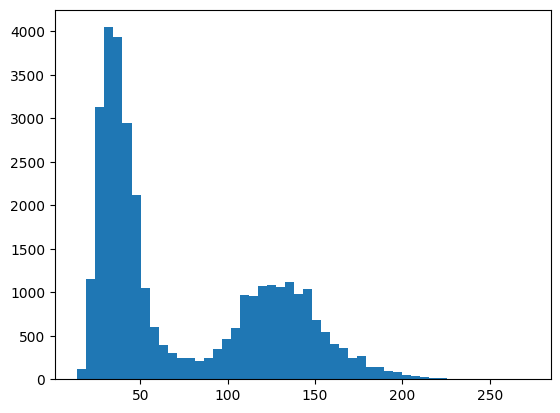

In [ ]:
plt.hist([len(sample['text'].split()) for sample in ds['train']], 50)
plt.show()

In [ ]:
max_length = 400

def tokenize(examples):
    inputs = tokenizer(examples["text"], truncation=True,
                       max_length=max_length, return_overflowing_tokens=True)
    return inputs

ds_encoded = ds.map(tokenize, batched=True, remove_columns=ds["train"].column_names)
ds_encoded

Map:   0%|          | 0/33547 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 33547
    })
})

Create LoRA configuration for QLoRA

In [ ]:
adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 8,
    'lora_dropout': 0.05,
    'r': 8,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

prepared_model_4bit = prepare_model_for_kbit_training(model)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

qlora_model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.9391


In [ ]:
data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
wandb.init(mode="disabled")

In [ ]:
sample = [ds_encoded['train'][i]['input_ids'] for i in range(1)]
collated = data_collator(sample)

print(collated.keys())

dict_keys(['input_ids', 'labels'])


In [ ]:
train_args = TrainingArguments(
    num_train_epochs=20,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=16,
    learning_rate=1e-4,
    bf16=True,
    logging_steps=4,
    output_dir="outputs",
)
trainer = Trainer(
    model=qlora_model,
    processing_class=tokenizer,
    train_dataset=ds_encoded['train'],
    args=train_args,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,2.936100
2,2.922100
3,2.944300
4,2.940600
5,2.957400
6,2.940800
7,2.955100
8,2.951500
9,2.983400
10,2.912200


TrainOutput(global_step=65, training_loss=2.9433239790109487, metrics={'train_runtime': 3295.9664, 'train_samples_per_second': 10.178, 'train_steps_per_second': 0.02, 'total_flos': 3937540036902912.0, 'train_loss': 2.9433239790109487, 'epoch': 0.9918931807343825})

In [ ]:
trainer.save_model('./finedtuned_model')

### Chatbot with history

For this we use pretrained Phi-3-Mini-4K-Instruct.

In [ ]:
name = 'microsoft/Phi-3-mini-4k-instruct' # use a larger model
if name == 'microsoft/Phi-3-mini-4k-instruct':
  tokenizer = AutoTokenizer.from_pretrained(name)
  tokenizer.pad_token = tokenizer.eos_token
  model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,)

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda


In [ ]:
question = ds['train'][3000]['input']
print(question)
out = chatbot_with_context_and_history(question, messages, pipe=pipe, n_context=3)
answer = answer_template
answer[0]['content'] = out
messages.append(answer[0])
print(out)
if len(messages) > 10:
  messages = messages[2:]

What is late-onset neonatal conjunctivitis and what can cause it?
Late-onset neonatal conjunctivitis is an ocular infection that occurs in neonates between 1-2 weeks of age. It is caused by a variety of bacterial, viral, and fungal pathogens, but one common cause is Chlamydia trachomatis serotypes D-K infection during childbirth. This type of conjunctivitis can lead to conjunctival scarring, corneal opacification, and other complications if left untreated. Treatment typically involves topical or systemic antibiotics, and prompt diagnosis and treatment are important to prevent long-term damage to the eyes. Other preventative measures, such as screening and treating pregnant women for sexually transmitted infections, can also help to reduce the incidence of late-onset neonatal conjunctivitis.
